# Projeto Roberta 

### Ideia do projeto: Determinar a temperatura de um corpo negro e calcular a incerteza relacionada ao resultado

##### Código:


- Primeiro passo: imports necessários

In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
import astropy.units as u
from scipy.stats import chi2
import scipy.stats as stats

##### Carregando o arquivo que será utilizado:


lamb = Lambda, em micron

flux_obs = Potência emissiva espectral (E), em W / ( m2 * micron)


In [2]:
x,y = np.loadtxt('corpo_negro_Roberta.txt', unpack=True)

lamb = x * u.micron
flux_obs = y * u.W * u.micron**-1 * u.m**-2

Plot do espectro dos nossos dados para vizualização:

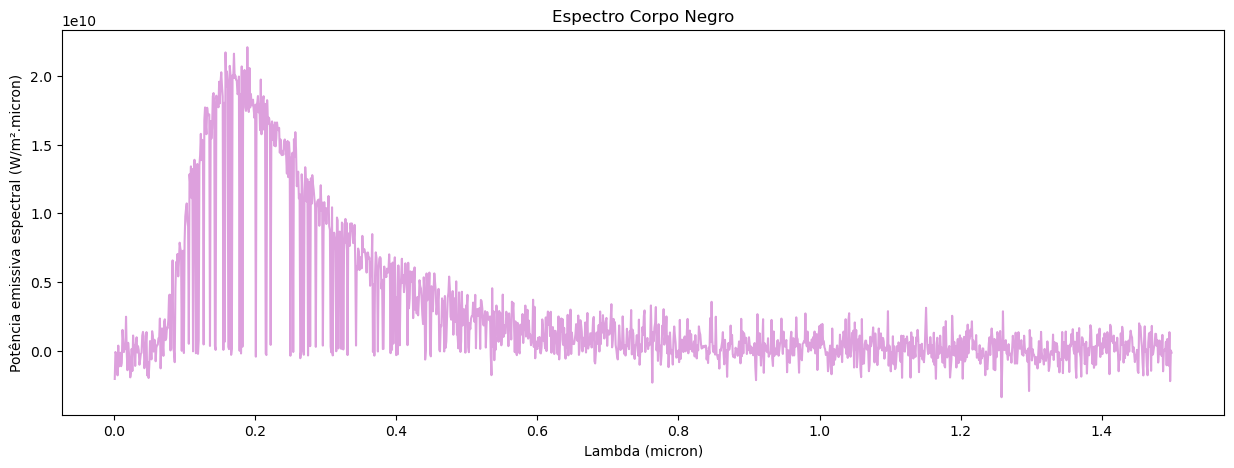

In [3]:
plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb,flux_obs,'plum')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Potência emissiva espectral (W/m².micron)')
plt.show()


Definindo a função que nos resultará os resíduos por método de mínimos quadrados, testando várias temperaturas

In [4]:
def eq_corpo_negro(lamb, temperatura):
    c1 = 3.742*(10**8)*(u.W)*(u.micron**4)*(u.m**-2)
    c2 = 1.44*(10**4)*(u.micron)*(u.K)
    fluxo_mod = c1/((lamb**5)*(-1 + np.exp((c2/(lamb*temperatura)))))
    return fluxo_mod


def soma_quadrados_residuos(temperatura, lamb_obs, flux_obs):
    flux_modelado = eq_corpo_negro(lamb_obs, temperatura)
    residuos = flux_obs - flux_modelado
    return np.sum(residuos**2)

somas_quadrados_residuos = []



Definindo o primeiro array de temperaturas a serem testadas:

In [5]:
temperaturas_teste = np.arange(1000, 50000, 100)*u.K

Testando as temperaturas pelas funções definidas:
    

In [6]:

for i in range(len(temperaturas_teste)):
    S = soma_quadrados_residuos(temperaturas_teste[i], lamb, flux_obs)
    somas_quadrados_residuos.append(S.value)

residuos = np.array(somas_quadrados_residuos)

/usr/lib/python3/dist-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Procurando a partir do argmin qual temperatura nos resultou o menor resíduo:

In [7]:
temperaturas_teste[np.argmin(residuos)]

<Quantity 16600. K>

Plotando um gráfico de temperatura X residuos para melhor visualização:
linha traçejada colocada onde está a temperatura com menor resíduo

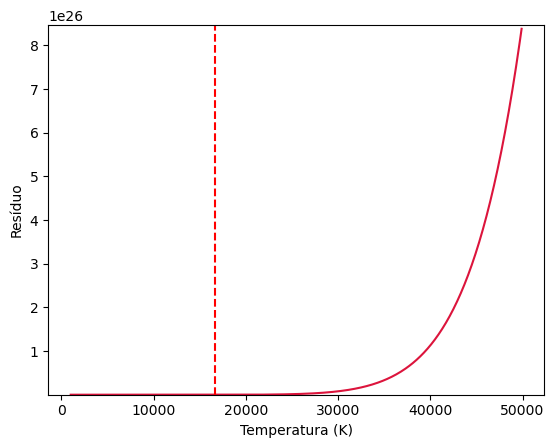

In [8]:
plt.plot(temperaturas_teste,residuos,color='crimson')
plt.ylim(0.99*np.min(somas_quadrados_residuos), 1.01*np.max(somas_quadrados_residuos))
plt.xlabel('Temperatura (K)')         
plt.ylabel('Resíduo')
plt.axvline(temperaturas_teste[np.argmin(residuos)].value,color='r',linestyle='--')
plt.show()

Calculando nosso fluxo modelo com a melhor temperatura encontrada no teste e comparando com o fluxo observado:

/usr/lib/python3/dist-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


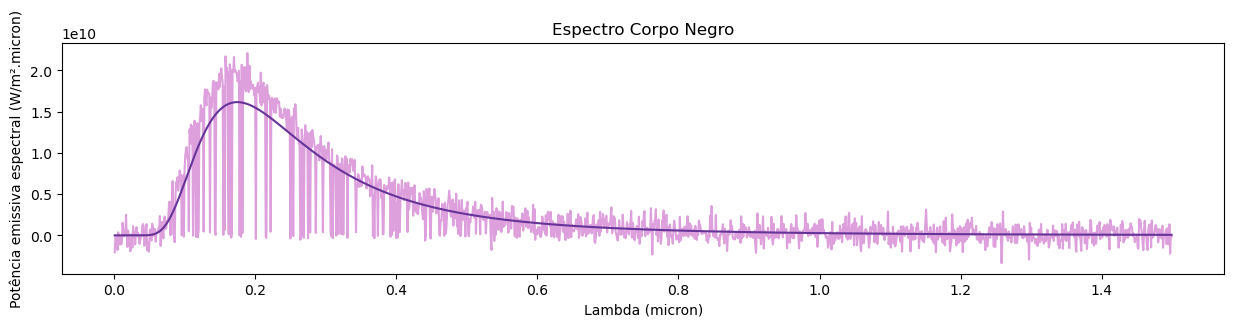

In [9]:
flux_mod = eq_corpo_negro(lamb, 16600*u.K)

plt.figure(figsize=[15, 3], facecolor='white')
plt.plot(lamb,flux_obs,'plum')
plt.plot(lamb,flux_mod,'rebeccapurple')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Potência emissiva espectral (W/m².micron)')
plt.show()


Plotando os resíduos e demarcando linhas em +- 3 sigma:

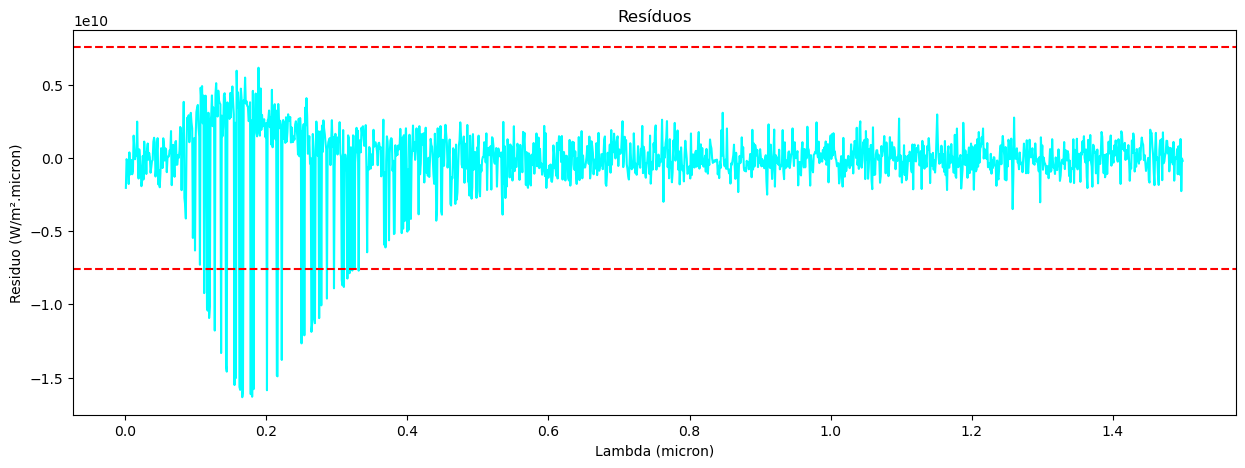

In [18]:
plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb, flux_obs - flux_mod, 'aqua')
plt.axhline(+3 * np.std(flux_obs.value - flux_mod.value), color='r', linestyle='--')
plt.axhline(-3 * np.std(flux_obs.value - flux_mod.value), color='r', linestyle='--')
plt.title('Resíduos') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.show()


Valores de + e - 3 sigma:

In [11]:
3*np.std(flux_obs.value - flux_mod.value)

7555933555.084766

In [12]:
-3*np.std(flux_obs.value - flux_mod.value)

-7555933555.084766

criando uma máscara para retirar os pontos que ultrapassam os 3 sigmas:

In [13]:
res = flux_obs.value - flux_mod.value
mask = abs(res) < 3*res.std()

Plotando novamente os resíduos com cores diferentes para os que foram retirados para vizualização:

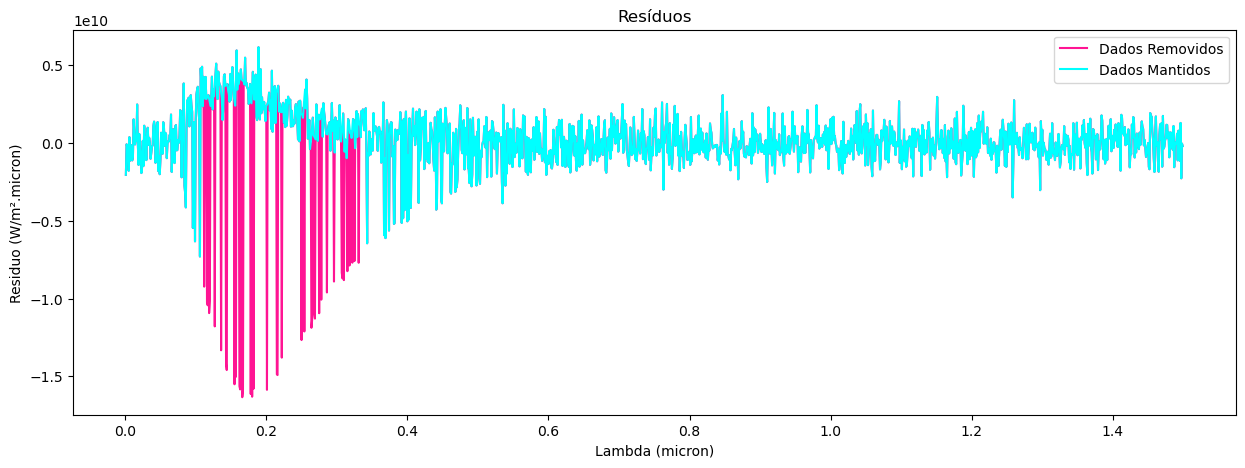

In [19]:
plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb, flux_obs - flux_mod, 'deeppink', label='Dados Removidos')
plt.plot(lamb[mask], flux_obs[mask] - flux_mod[mask], 'aqua', label='Dados Mantidos')
plt.title('Resíduos') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.legend()
plt.show()



Definindo novos lambda e fluxo para os que estão dentro do intervalo de 3 sigma:

In [20]:
lamb_1 = lamb[mask]
flux_obs_1 = flux_obs[mask]

Plot do novo espectro corrigido:

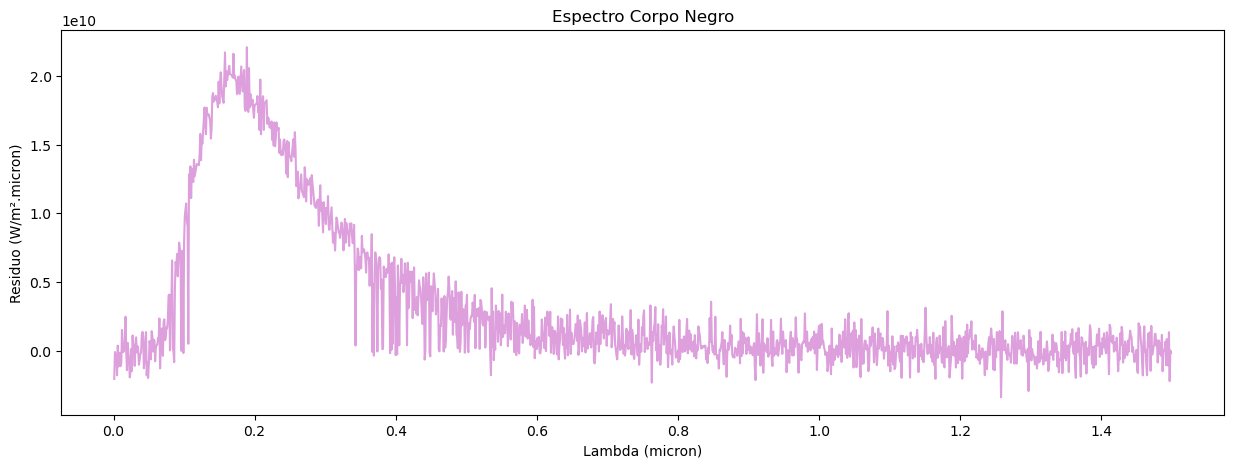

In [21]:
plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_1,flux_obs_1,'plum')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.show()

##### Refazendo:

- Refazendo o processo para ajustar novamente os dados, com os mesmo passos anteriores, para tentar remover mais ruídos

Definindo um novo array de temperaturas baseado no gráfico temperatura x resíduos:

In [22]:
temperaturas_teste = np.arange(1000, 30000, 100)*u.K

In [23]:
somas_quadrados_residuos = []

for i in range(len(temperaturas_teste)):
    S = soma_quadrados_residuos(temperaturas_teste[i], lamb_1, flux_obs_1)
    somas_quadrados_residuos.append(S.value)
    
residuos = np.array(somas_quadrados_residuos)

/usr/lib/python3/dist-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


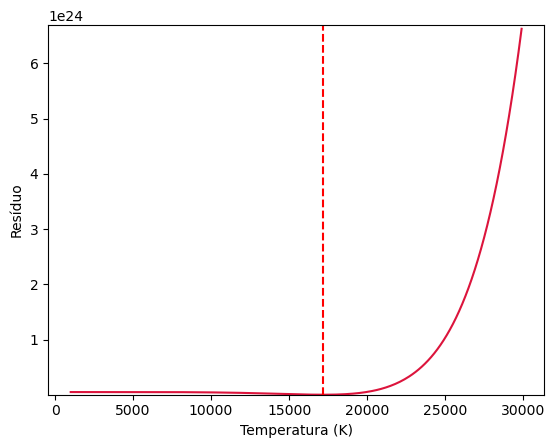

In [24]:
plt.plot(temperaturas_teste,somas_quadrados_residuos,'crimson')
plt.xlabel('Temperatura (K)')         
plt.ylabel('Resíduo')
plt.axvline(temperaturas_teste[np.argmin(residuos)].value,color='r',linestyle='--')
plt.ylim(0.99*np.min(somas_quadrados_residuos), 1.01*np.max(somas_quadrados_residuos))
plt.show()

In [25]:
temperaturas_teste[np.argmin(residuos)]

<Quantity 17200. K>

/usr/lib/python3/dist-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


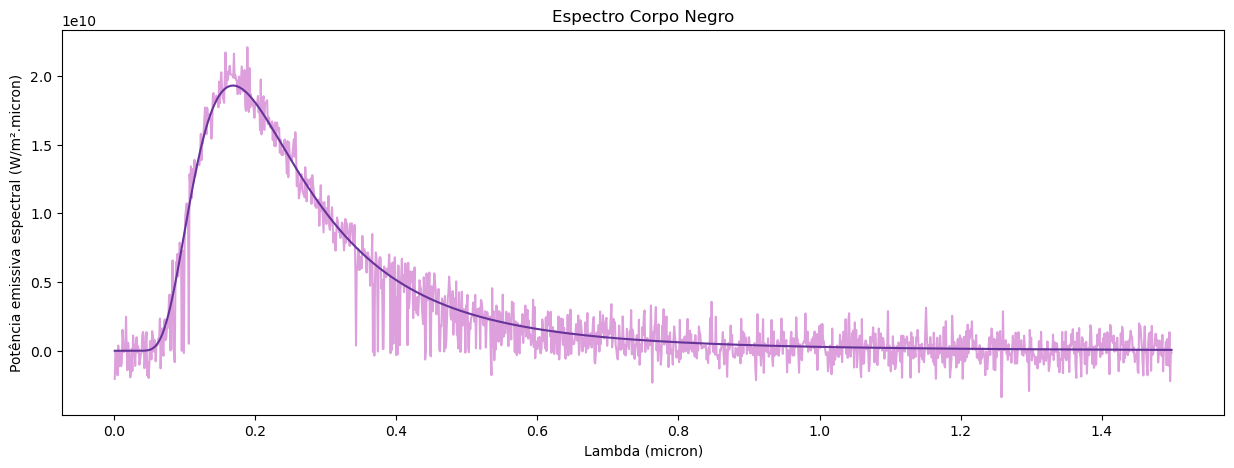

In [26]:
flux_mod = eq_corpo_negro(lamb_1, 17200*u.K)

plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_1,flux_obs_1,'plum')
plt.plot(lamb_1,flux_mod,'rebeccapurple')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Potência emissiva espectral (W/m².micron)')
plt.show()


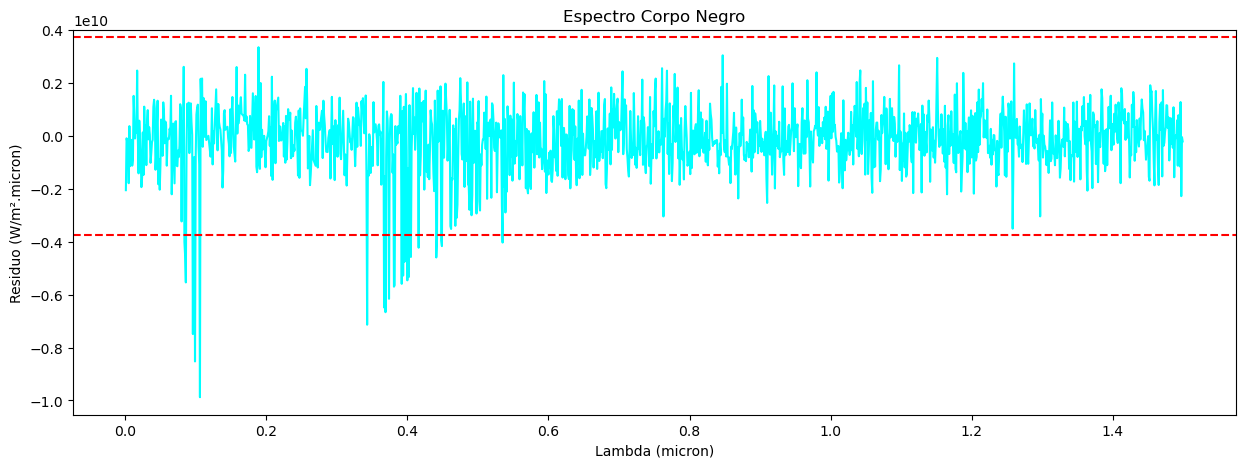

In [27]:
plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_1,flux_obs_1 - flux_mod,'aqua')
plt.axhline(+3*np.std(flux_obs_1.value - flux_mod.value),color='r',linestyle='--')
plt.axhline(-3*np.std(flux_obs_1.value - flux_mod.value),color='r',linestyle='--')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.show()


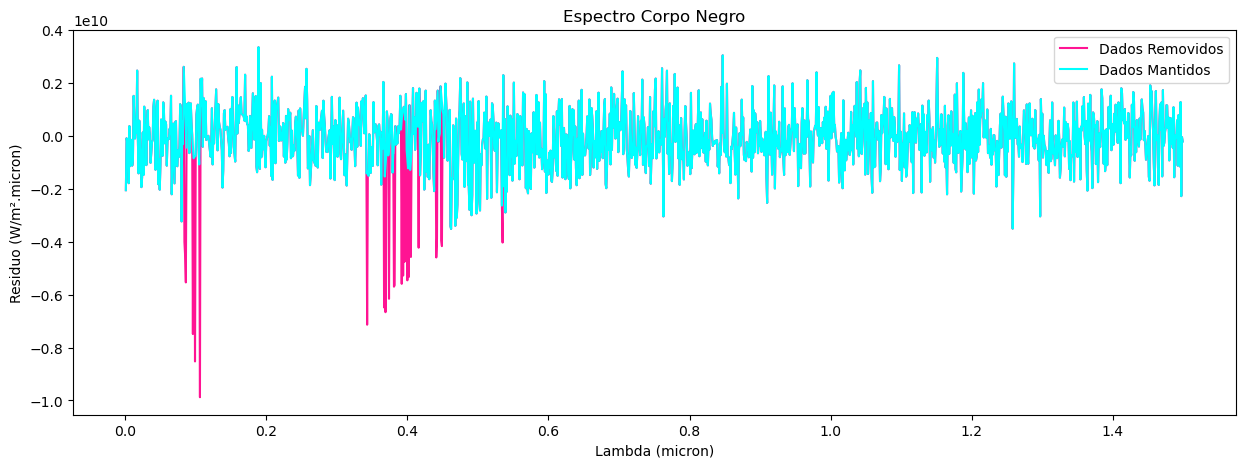

In [30]:
res = flux_obs_1.value - flux_mod.value

mask = abs(res) < 3*res.std()

plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_1,flux_obs_1 - flux_mod,'deeppink', label='Dados Removidos')
plt.plot(lamb_1[mask],flux_obs_1[mask] - flux_mod[mask],'aqua',label='Dados Mantidos')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.legend()
plt.show()

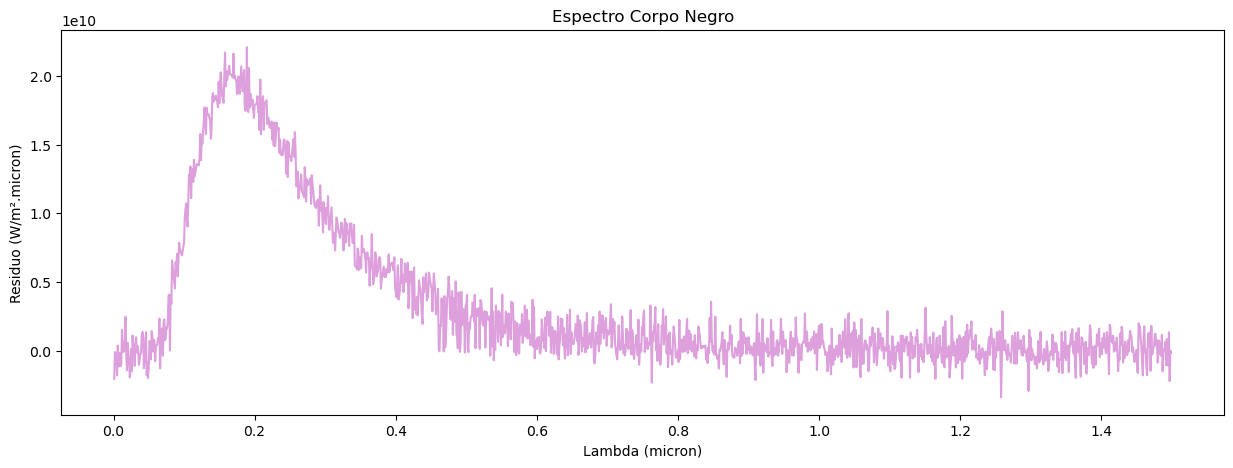

In [31]:
lamb_2 = lamb_1[mask]
flux_obs_2 = flux_obs_1[mask]

plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_2,flux_obs_2,'plum')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.show()

##### Refazendo:

In [32]:
temperaturas_teste = np.arange(10000, 20000, 50)*u.K

In [33]:
somas_quadrados_residuos = []

for i in range(len(temperaturas_teste)):
    S = soma_quadrados_residuos(temperaturas_teste[i], lamb_2, flux_obs_2)
    somas_quadrados_residuos.append(S.value)
    
residuos = np.array(somas_quadrados_residuos)

/usr/lib/python3/dist-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


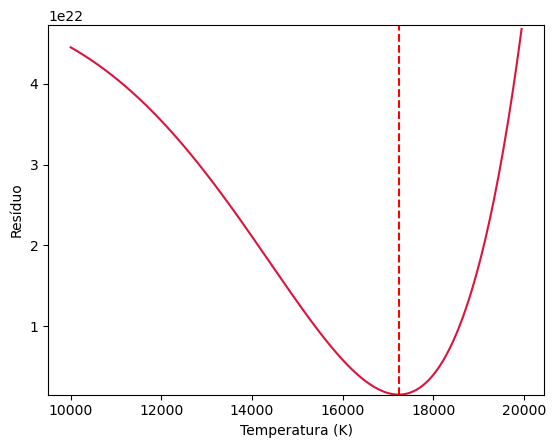

In [34]:
plt.plot(temperaturas_teste,somas_quadrados_residuos,color='crimson')
plt.ylim(0.99*np.min(somas_quadrados_residuos), 1.01*np.max(somas_quadrados_residuos))
plt.xlabel('Temperatura (K)')         
plt.ylabel('Resíduo')
plt.axvline(temperaturas_teste[np.argmin(residuos)].value,color='r',linestyle='--')
plt.show()

In [35]:
temperaturas_teste[np.argmin(residuos)]

<Quantity 17250. K>

/usr/lib/python3/dist-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


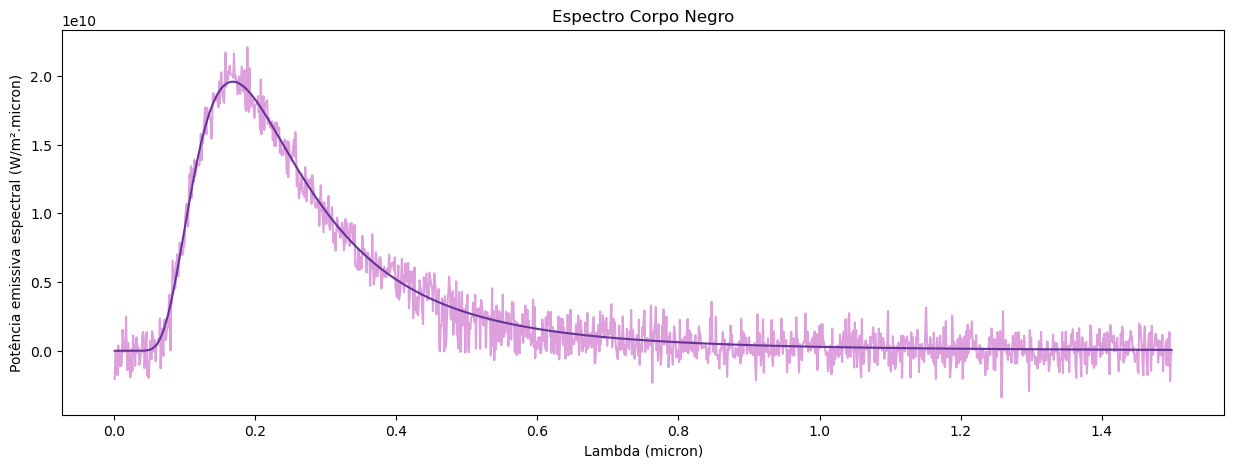

In [37]:
flux_mod = eq_corpo_negro(lamb_2, 17250*u.K)

plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_2,flux_obs_2,'plum')
plt.plot(lamb_2,flux_mod,'rebeccapurple')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Potência emissiva espectral (W/m².micron)')
plt.show()

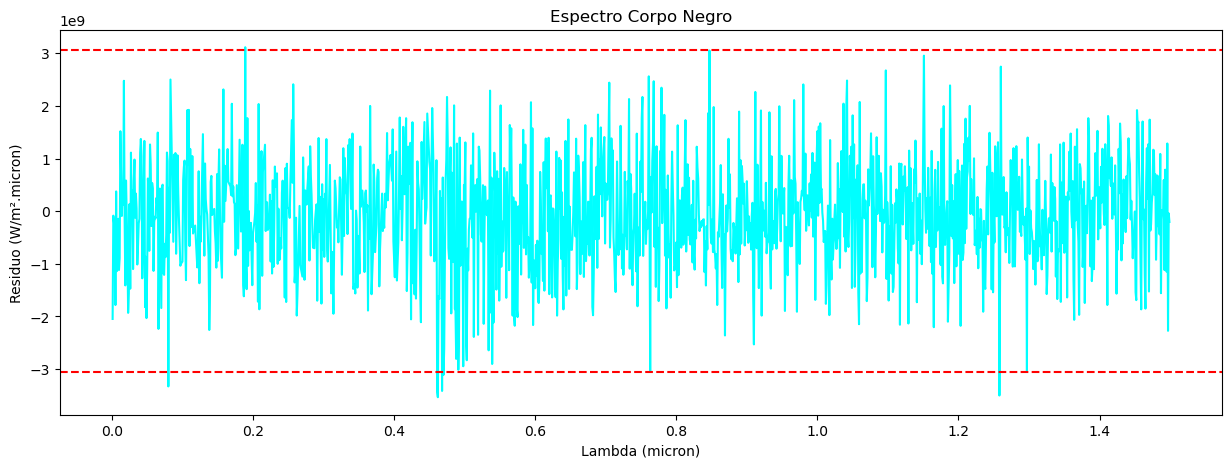

In [38]:
plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_2,flux_obs_2 - flux_mod,'aqua')
plt.axhline(+3*np.std(flux_obs_2.value - flux_mod.value),color='red',linestyle='--')
plt.axhline(-3*np.std(flux_obs_2.value - flux_mod.value),color='red',linestyle='--')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.show()


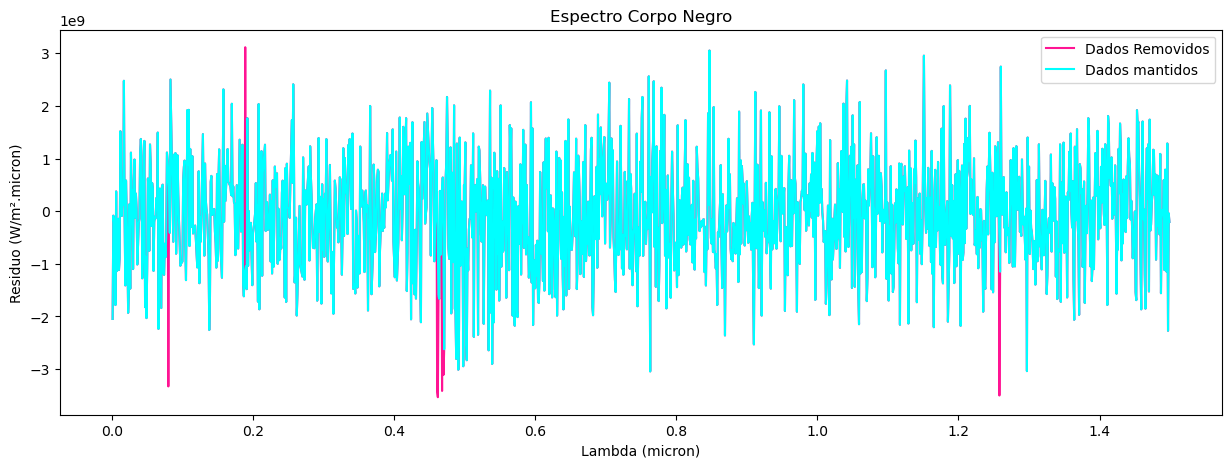

In [39]:
res = flux_obs_2.value - flux_mod.value

mask = abs(res) < 3*res.std()

plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_2,flux_obs_2 - flux_mod,'deeppink',label='Dados Removidos')
plt.plot(lamb_2[mask],flux_obs_2[mask] - flux_mod[mask],'aqua',label='Dados mantidos')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.legend()
plt.show()

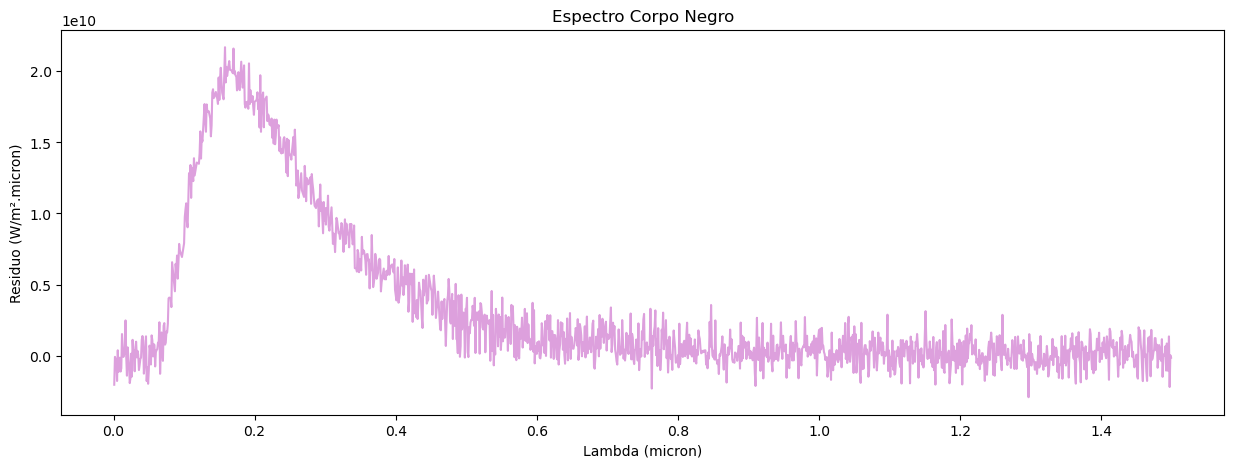

In [40]:
lamb_3 = lamb_2[mask]
flux_obs_3 = flux_obs_2[mask]

plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_3,flux_obs_3,'plum')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.show()

##### Refazendo:

In [41]:
temperaturas_teste = np.arange(16000, 18000, 10)*u.K

/usr/lib/python3/dist-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


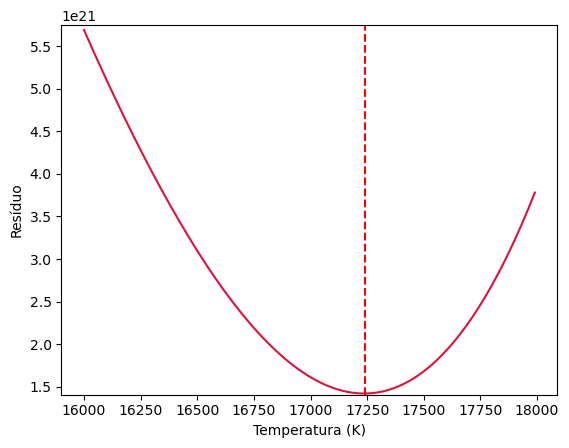

In [42]:
somas_quadrados_residuos = []

for i in range(len(temperaturas_teste)):
    S = soma_quadrados_residuos(temperaturas_teste[i], lamb_3, flux_obs_3)
    somas_quadrados_residuos.append(S.value)
    
residuos = np.array(somas_quadrados_residuos)

plt.plot(temperaturas_teste,somas_quadrados_residuos,color='crimson')
plt.xlabel('Temperatura (K)')         
plt.ylabel('Resíduo')
plt.axvline(temperaturas_teste[np.argmin(residuos)].value,color='r',linestyle='--')
plt.ylim(0.99*np.min(somas_quadrados_residuos), 1.01*np.max(somas_quadrados_residuos))
plt.show()

In [43]:
temperaturas_teste[np.argmin(residuos)]

<Quantity 17240. K>

/usr/lib/python3/dist-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


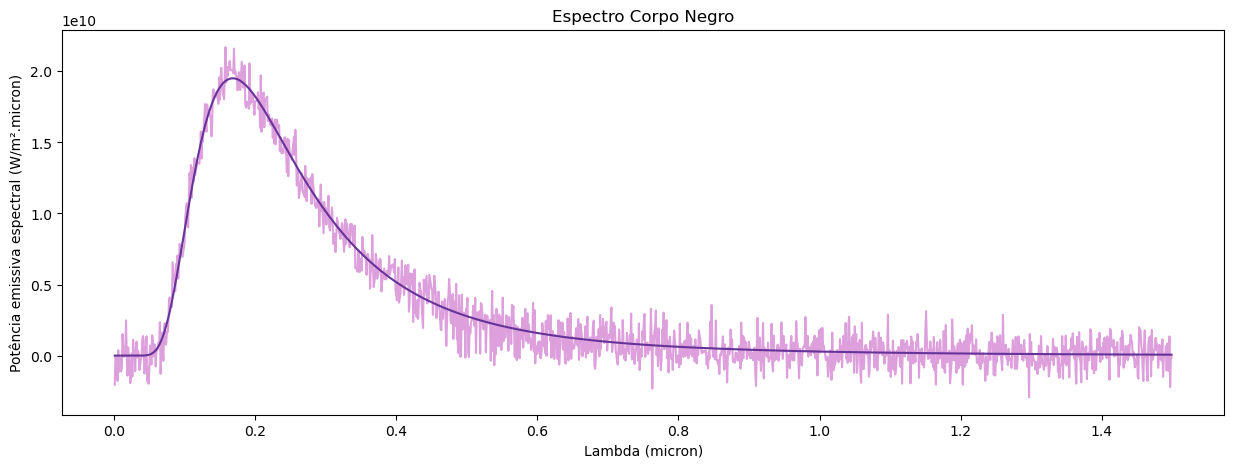

In [44]:
flux_mod = eq_corpo_negro(lamb_3, 17240*u.K)

plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_3,flux_obs_3,'plum')
plt.plot(lamb_3,flux_mod,'rebeccapurple')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Potência emissiva espectral (W/m².micron)')
plt.show()

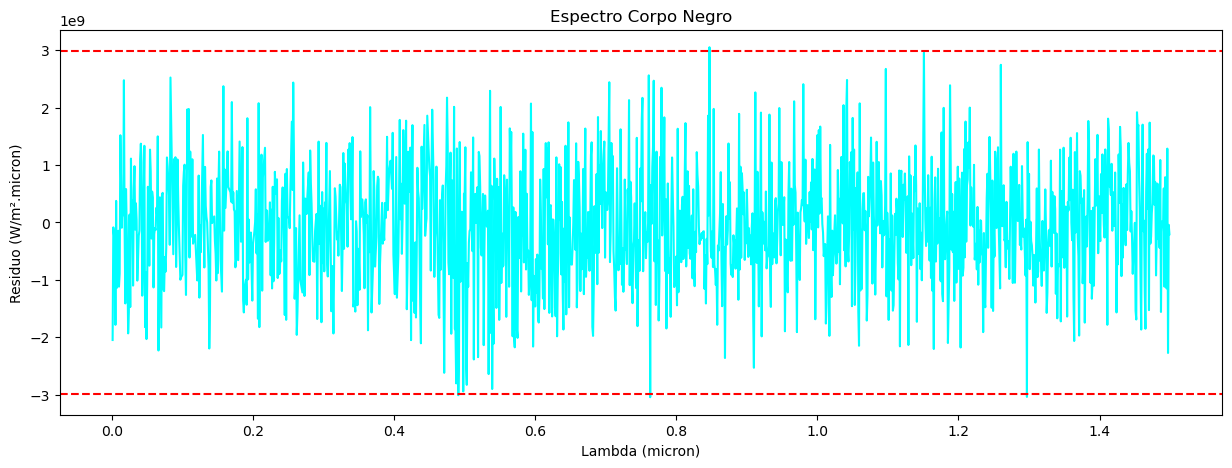

In [45]:
plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_3,flux_obs_3 - flux_mod,'aqua')
plt.axhline(+3*np.std(flux_obs_3.value - flux_mod.value),color='r',linestyle='--')
plt.axhline(-3*np.std(flux_obs_3.value - flux_mod.value),color='r',linestyle='--')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.show()


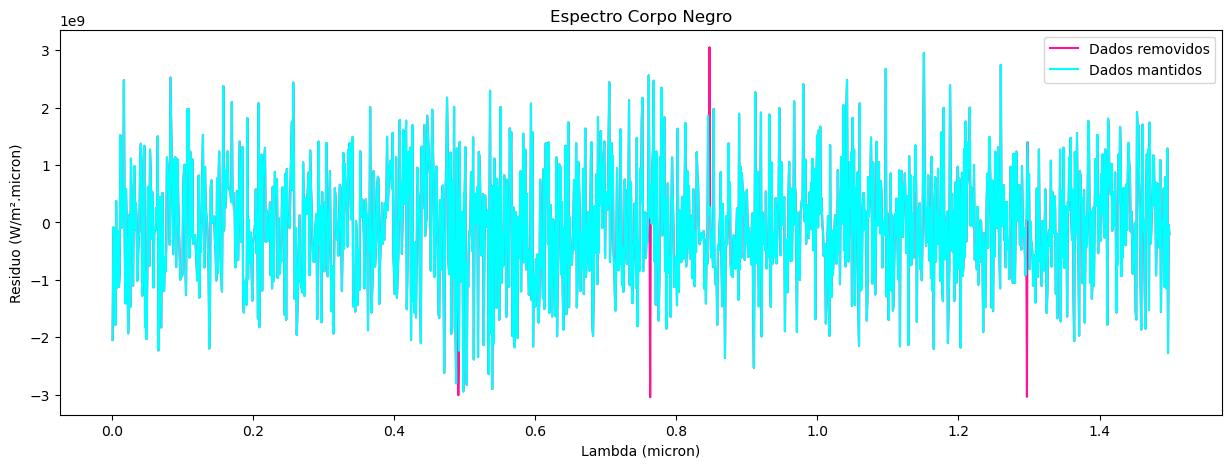

In [46]:
res = flux_obs_3.value - flux_mod.value

mask = abs(res) < 3*res.std()

plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_3,flux_obs_3 - flux_mod,'deeppink',label='Dados removidos')
plt.plot(lamb_3[mask],flux_obs_3[mask] - flux_mod[mask],'aqua',label='Dados mantidos')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.legend()
plt.show()

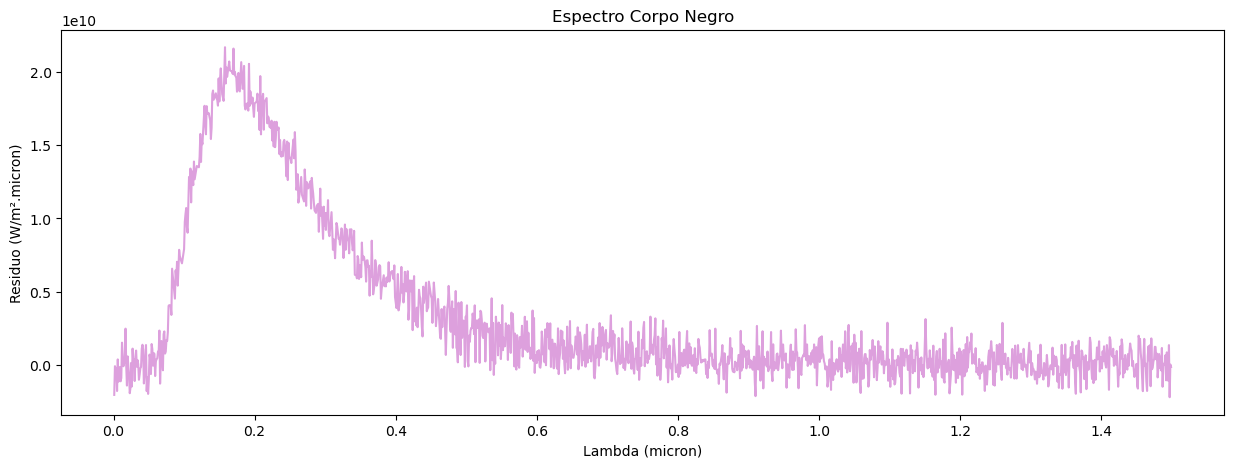

In [47]:
lamb_4 = lamb_3[mask]
flux_obs_4 = flux_obs_3[mask]

plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_4,flux_obs_4,'plum')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.show()

##### Refazendo:

In [48]:
temperaturas_teste = np.arange(17000, 17500,1)*u.K

/usr/lib/python3/dist-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


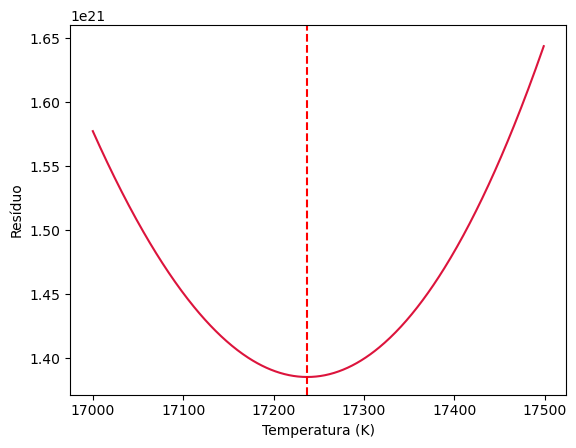

In [49]:
somas_quadrados_residuos = []

for i in range(len(temperaturas_teste)):
    S = soma_quadrados_residuos(temperaturas_teste[i], lamb_4, flux_obs_4)
    somas_quadrados_residuos.append(S.value)
    
residuos = np.array(somas_quadrados_residuos)

plt.plot(temperaturas_teste,somas_quadrados_residuos,color='crimson')
plt.xlabel('Temperatura (K)')         
plt.ylabel('Resíduo')
plt.axvline(temperaturas_teste[np.argmin(residuos)].value,color='r',linestyle='--')
plt.ylim(0.99*np.min(somas_quadrados_residuos), 1.01*np.max(somas_quadrados_residuos))
plt.show()

In [50]:
temperaturas_teste[np.argmin(residuos)]

<Quantity 17237. K>

/usr/lib/python3/dist-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


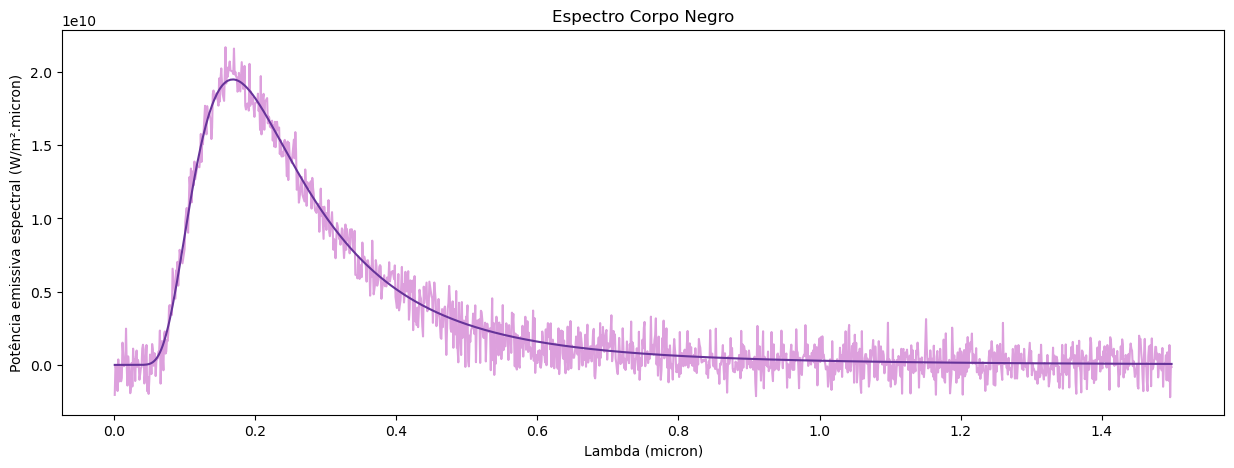

In [51]:
flux_mod = eq_corpo_negro(lamb_4, 17237*u.K)

plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_4,flux_obs_4,'plum')
plt.plot(lamb_4,flux_mod,'rebeccapurple')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Potência emissiva espectral (W/m².micron)')
plt.show()

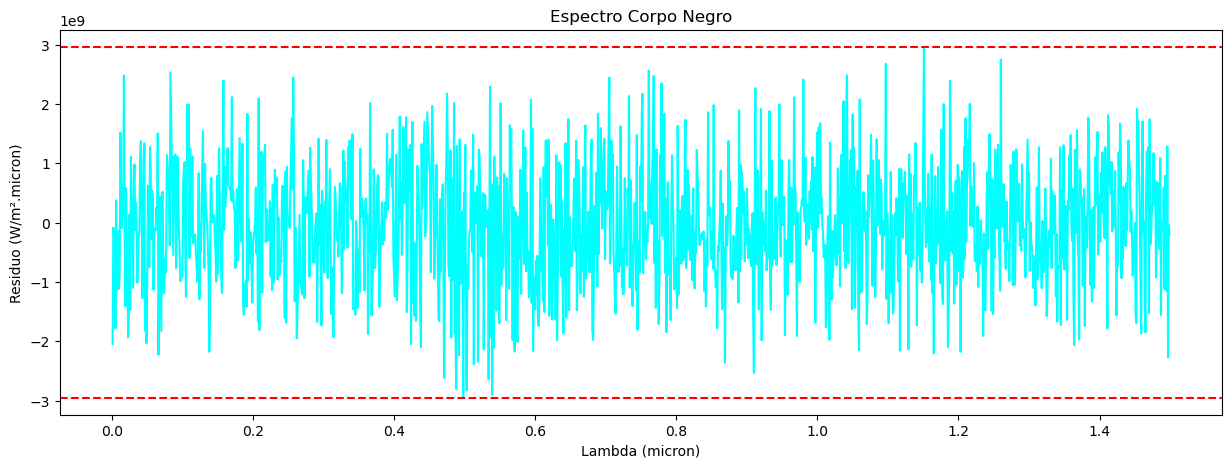

In [52]:
plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_4,flux_obs_4 - flux_mod,'aqua')
plt.axhline(+3*np.std(flux_obs_4.value - flux_mod.value),color='red',linestyle='--')
plt.axhline(-3*np.std(flux_obs_4.value - flux_mod.value),color='red',linestyle='--')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.show()


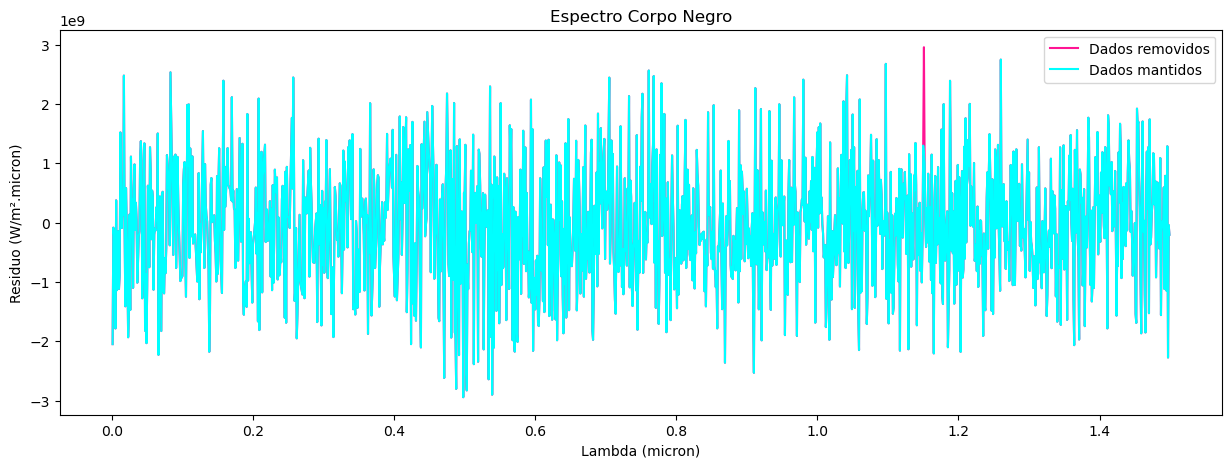

In [54]:
res = flux_obs_4.value - flux_mod.value

mask = abs(res) < 3*res.std()

plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_4,flux_obs_4 - flux_mod,'deeppink',label='Dados removidos')
plt.plot(lamb_4[mask],flux_obs_4[mask] - flux_mod[mask],'aqua',label='Dados mantidos')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.legend()
plt.show()

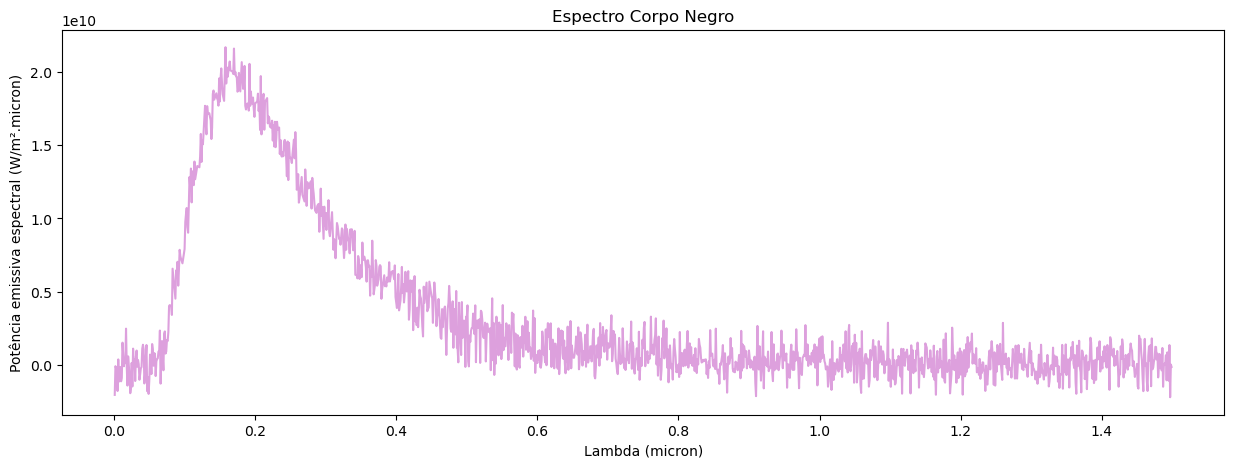

In [55]:
lamb_5 = lamb_4[mask]
flux_obs_5 = flux_obs_4[mask]

plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_5,flux_obs_5,'plum')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Potência emissiva espectral (W/m².micron)')
plt.show()

##### Refazendo:

In [56]:
temperaturas_teste = np.arange(17200, 17300,1)*u.K

/usr/lib/python3/dist-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


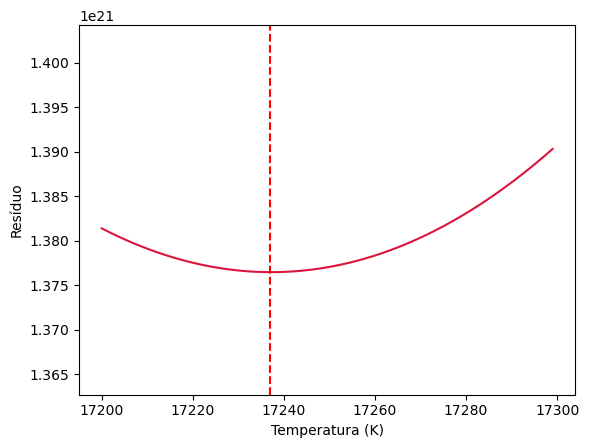

In [57]:
somas_quadrados_residuos = []

for i in range(len(temperaturas_teste)):
    S = soma_quadrados_residuos(temperaturas_teste[i], lamb_5, flux_obs_5)
    somas_quadrados_residuos.append(S.value)
    
residuos = np.array(somas_quadrados_residuos)

plt.plot(temperaturas_teste,somas_quadrados_residuos,color='crimson')
plt.xlabel('Temperatura (K)')         
plt.ylabel('Resíduo')
plt.axvline(temperaturas_teste[np.argmin(residuos)].value,color='r',linestyle='--')
plt.ylim(0.99*np.min(somas_quadrados_residuos), 1.01*np.max(somas_quadrados_residuos))
plt.show()

In [58]:
temperaturas_teste[np.argmin(residuos)]

<Quantity 17237. K>

/usr/lib/python3/dist-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


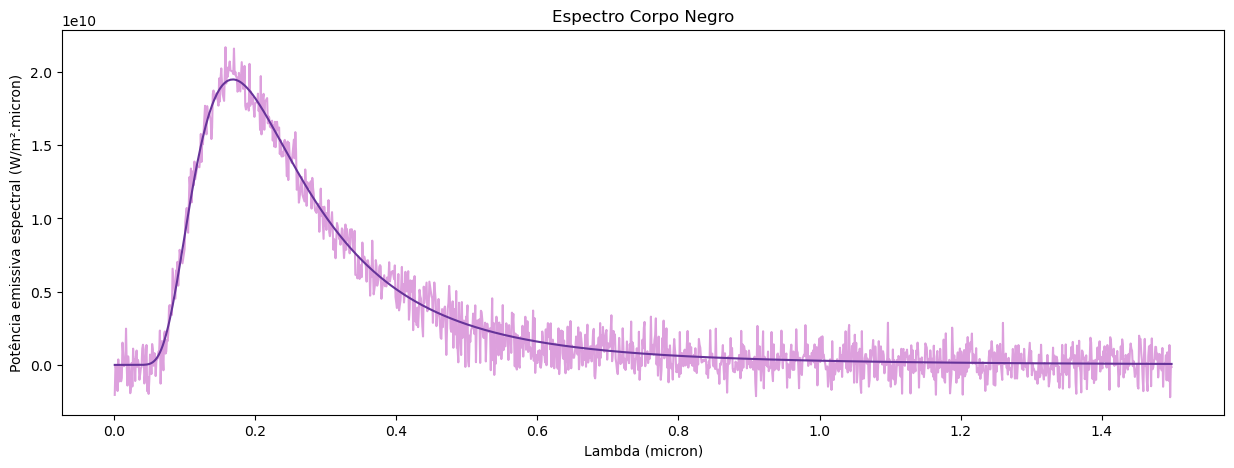

In [59]:
flux_mod = eq_corpo_negro(lamb_5, 17237*u.K)

plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_5,flux_obs_5,'plum')
plt.plot(lamb_5,flux_mod,'rebeccapurple')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Potência emissiva espectral (W/m².micron)')
plt.show()

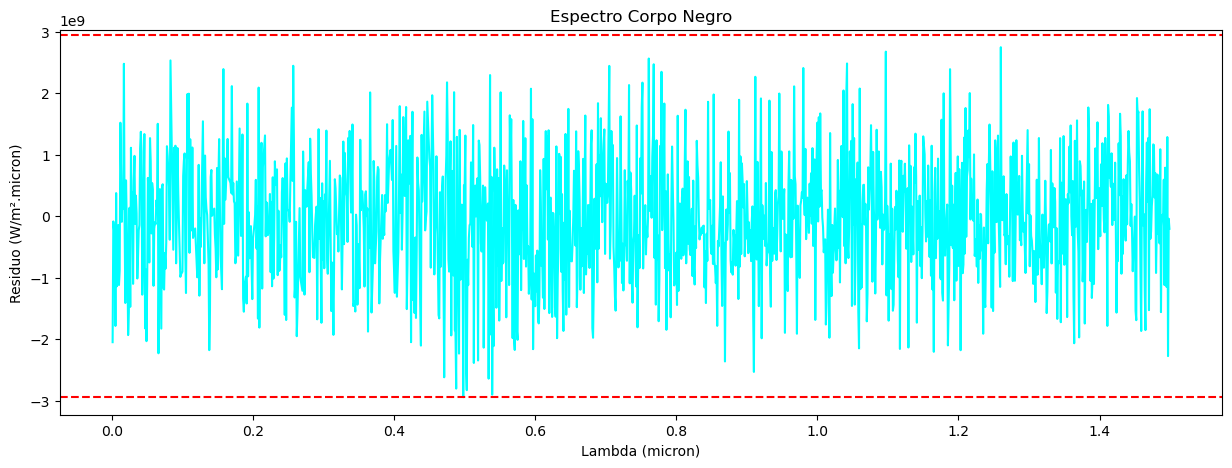

In [60]:
plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_5,flux_obs_5 - flux_mod,'aqua')
plt.axhline(+3*np.std(flux_obs_5.value - flux_mod.value),color='red',linestyle='--')
plt.axhline(-3*np.std(flux_obs_5.value - flux_mod.value),color='red',linestyle='--')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.show()

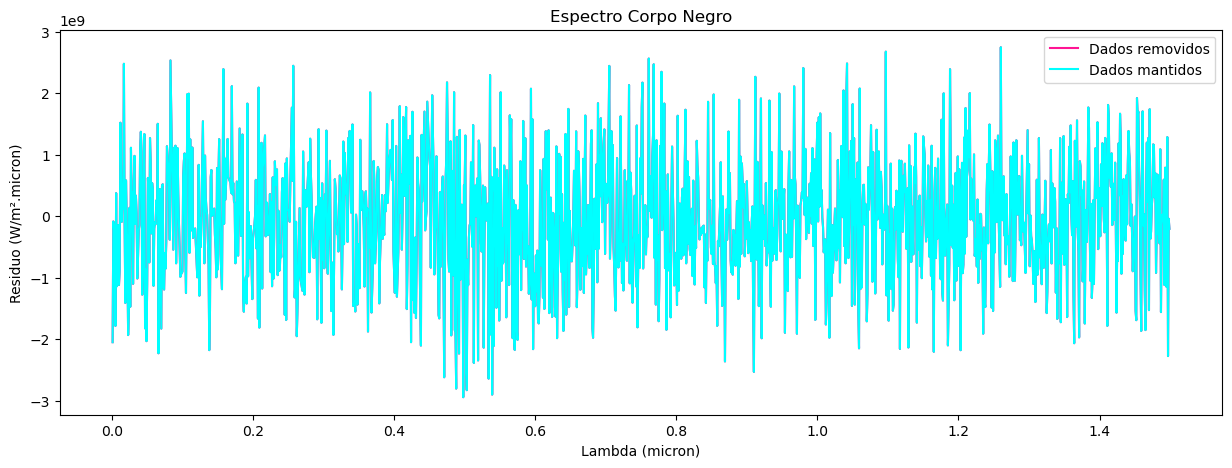

In [61]:
res = flux_obs_5.value - flux_mod.value

mask = abs(res) < 3*res.std()

plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_5,flux_obs_5 - flux_mod,'deeppink',label='Dados removidos')
plt.plot(lamb_5[mask],flux_obs_5[mask] - flux_mod[mask],'aqua',label='Dados mantidos')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Residuo (W/m².micron)')
plt.legend()
plt.show()

Chegamos a uma temperatura igual a da última vez e não temos mais pontos fora de 3* o desvio padrão, portanto, chegamos a melhor temperatura que poderíamos

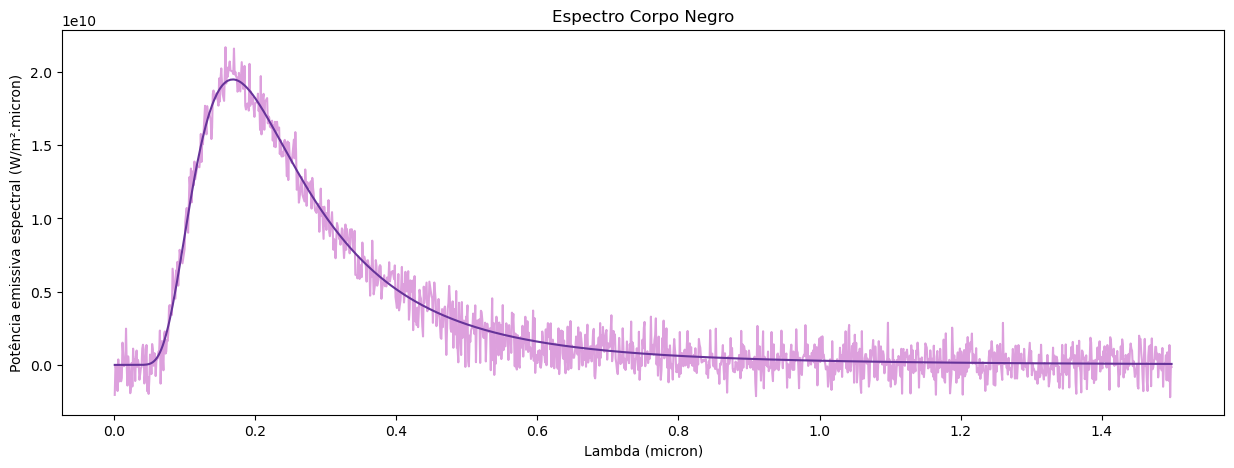

In [62]:
lamb_final = lamb_5[mask]
flux_obs_final = flux_obs_5[mask]

plt.figure(figsize=[15, 5], facecolor='white')
plt.plot(lamb_final,flux_obs_final,'plum')
plt.plot(lamb_final,flux_mod,'rebeccapurple')
plt.title('Espectro Corpo Negro') 
plt.xlabel('Lambda (micron)')         
plt.ylabel('Potência emissiva espectral (W/m².micron)')
plt.show()

calculando agora o chi2 para definirmos os valores de sigma:

criando um array pra colocar os valores de chi² e definindo o quadrado do desvio padrão em uma variável pra utilizála na função de cáculo do chi²

In [63]:
chi2 = np.array([])
quad_desvio=(np.std(flux_obs_final - flux_mod))**2

fazendo a função que vai nos dar os valores do chi²

In [64]:

for i in range(len(temperaturas_teste)):
    
    flux_modelo = eq_corpo_negro(lamb_final, temperaturas_teste[i])
    quad_residuo=(flux_obs_final - flux_modelo)**2
    chi_2 = np.sum((quad_residuo)/(quad_desvio))
    chi2=np.append(chi2,chi_2.value)

/usr/lib/python3/dist-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


plot do chi² em função da temperatura com linhas demarcando os valores dentro de um intervalo de confiança de 1, 2 e 3 sigma:

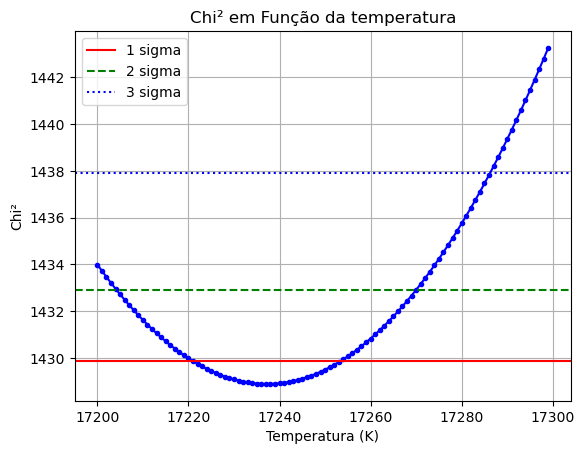

In [65]:


sigma_1 = chi2.min()+1

sigma_2 = chi2.min()+4

sigma_3 = chi2.min()+9

plt.plot(temperaturas_teste.value, chi2, 'b.-')
plt.xlabel('Temperatura (K)')
plt.ylabel('Chi²')
plt.title('Chi² em Função da temperatura')
plt.grid(True)
plt.axhline(sigma_1, color='r', ls='-', label='1 sigma')
plt.axhline(sigma_2, color='g', ls='--', label='2 sigma')
plt.axhline(sigma_3, color='b', ls=':', label='3 sigma')

plt.legend()



In [67]:
print('A temperatura estimada do corpo negro é 17237 ± {:.2f} K dentro de um intervalo de 68,3% de confiança'.format(sigma_1))
print('A temperatura estimada do corpo negro é 17237 ± {:.2f} K dentro de um intervalo de 95.4% de confiança'.format(sigma_2))
print('A temperatura estimada do corpo negro é 17237 ± {:.2f} K dentro de um intervalo de 99,7% de confiança'.format(sigma_3))


A temperatura estimada do corpo negro é 17237 ± 1429.89 K dentro de um intervalo de 68,3% de confiança
A temperatura estimada do corpo negro é 17237 ± 1432.89 K dentro de um intervalo de 95.4% de confiança
A temperatura estimada do corpo negro é 17237 ± 1437.89 K dentro de um intervalo de 99,7% de confiança
